In [74]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import scipy.signal as signal
from scipy.optimize import curve_fit

In [75]:
def psd(pathFolders, windows = 10, factor=1, channel='ch1'):
    data = []
    for file in os.listdir(pathFolders):
        if file.endswith('.pkl'):
            filePath = os.path.join(pathFolders,file)
            data.append(pd.read_pickle(filePath))            
    dt = data[0].t[1]-data[0].t[0]
    f = 1/dt
    freq, power = signal.welch(data[0][channel]*factor, f, window = 'hamming', nperseg = int(len(data[0][channel])/windows))
    for i in range(1,len(data)):
        freq, powerTemp = signal.welch(data[i][channel]*factor, f, window = 'hamming', nperseg = int(len(data[i][channel])/windows))
        power += powerTemp/np.sqrt((2*np.pi))
    power = power/len(data)
    return freq,power

In [2]:
def lorentzian(omega,A,center,gamma,base):
    num = A*gamma
    den = (center**2-omega**2)**2+omega**2*gamma**2
    return num/den + base



def psd_guess(freq,powerList,leftCrop = 40000,rightCrop = 120000,p0 = [0,0,0,0]):

    if 0 in p0:
        leftC,rightC = find_limits(freq,leftCrop,high = rightCrop)
        freq = freq[leftC:rightC]
        powerList = powerList[leftC:rightC]
        Max = max(powerList)
        Min = min(powerList)
        delta = Max - Min
        leftC,rightC = find_limits(powerList,Min+0.2*delta)
        freq = np.array(freq[leftC:rightC])
        powerList = np.array(powerList[leftC:rightC])
        #plt.plot(freq,powerList,alpha = 0.3)
        gamma_guess = freq[-1] - freq[0]
        center = (freq[-1] + freq[0])/2
        p0 = [Max*center*gamma_guess, center, gamma_guess,0]
    return freq,powerList,p0

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 22)

In [223]:
def fit_psd(folder, windows=20):
    freq, power = psd(folder, windows=windows, factor=1/(11*1.504e4))
    freq_cropped, power_cropped, p0 = psd_guess(freq, power)
    p0 =  [396360.1039417023, 79000.0, 314284.2758744481, 0]
    ans,cov = curve_fit(lorentzian, freq, power, p0=p0, absolute_sigma=True, maxfev=10000)
    fitted_power = lorentzian(freq, *ans)
    return power, fitted_power, freq, ans

In [224]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    return -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution

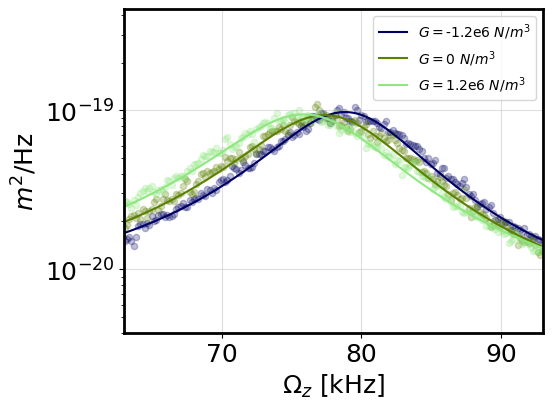

In [226]:
rootFolder = "../data/traces/batch_7"
windows = 10
gains = ['5052','0', '11332']

plt.rcParams.update({'font.size': 18})
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["figure.figsize"] = [5.4,4.2]
ax = plt.gca()
ax.grid(alpha = 0.4)
#colors = ['#1B4F72', '#2E86C1', '#85C1E9']
colors = ['#000064', '#5b8000', '#8ee77f']
labels = [r'$G=$', r'$G=$', r'$G=$']
factors = [0.8768, 1, 0.86]
for gain, color, label, factor in zip(gains, colors, labels, factors):

    
    power, fitted_power, freq, _ = fit_psd('{}/{}'.format(rootFolder, gain), windows=40)
    float_gain = convert_gains(int(gain))
    float_gain = np.round(11.27*3.03e-15*np.power(-11*1.504e4*float_gain,3)/1e6, 1)
    #    ax.fill_between(freq/1000, power,  color=color)
    if gain != '0':
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+str(float_gain)+r'e6 $N/m^3$')
    else:
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+'0'+r' $N/m^3$') 
    ax.scatter(freq/1000, power/factor, color=color, alpha=0.25, s=20, label='_{}'.format(label))
    ax.set_xlim([63, 93])
    ax.set_ylim([0.4*10**-20, 5*max(power)])
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set(ylabel=r'$m^2$/Hz')
    ax.set(xlabel=r'$\Omega_z$ [kHz]')
ax.legend(fontsize=10)##labels, fontsize=10, loc='upper right')
plt.savefig('../plots/psd_shifts_palette2.png', bbox_inches='tight')
plt.show()

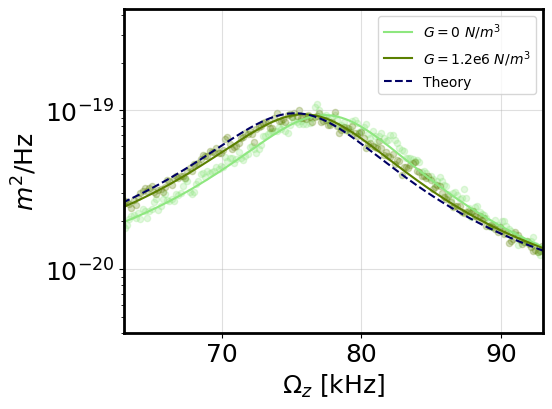

In [256]:
rootFolder = "../data/traces/batch_7"
windows = 10
gains = ['0', '11332']

plt.rcParams.update({'font.size': 18})
plt.rcParams["axes.linewidth"] = 2
plt.rcParams["figure.figsize"] = [5.4,4.2]
ax = plt.gca()
ax.grid(alpha = 0.4)
#colors = ['#85C1E9', '#1B4F72', '#2E86C1']
colors = ['#8ee77f', '#5b8000', '#000064']
labels = [r'$G=$', r'$G=$']
factors = [1, 0.86]
for gain, color, label, factor in zip(gains, colors[:2], labels, factors):

    
    power, fitted_power, freq, params = fit_psd('{}/{}'.format(rootFolder, gain), windows=40)
    float_gain = convert_gains(int(gain))
    float_gain = 11.27*3.03e-15*np.power(-11*1.504e4*float_gain,3)/1e6
    #    ax.fill_between(freq/1000, power,  color=color)
    if gain != '0':
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+str(np.round(float_gain, 1))+r'e6 $N/m^3$')
    else:
        ax.plot(freq/1000, fitted_power/factor, color=color, label=label+'0'+r' $N/m^3$') 
    ax.scatter(freq/1000, power/factor, color=color, alpha=0.25, s=20, label='_{}'.format(label))
    ax.set_xlim([63, 93])
    ax.set_ylim([0.4*10**-20, 5*max(power)])
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set(ylabel=r'$m^2$/Hz')
    ax.set(xlabel=r'$\Omega_z$ [kHz]')

params[1] = params[1]-0.0005179*float_gain*1e6
plt.plot(freq/1000, lorentzian(freq, *params)/factor, linestyle='dashed', color=colors[2], label='Theory')

ax.legend(fontsize=10)##labels, fontsize=10, loc='upper right')
plt.savefig('../plots/psd_shifts_theory_palette2.pdf', bbox_inches='tight')
plt.show()

In [230]:
gain

'11332'